In [ ]:
pip install inference-sdk

In [ ]:
# import the inference-sdk
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key=""
)
img = "test/photo_2_2025-04-01_00-17-27.jpg"

result = CLIENT.infer(img, model_id="your/modelID/1")
print(result)

{'inference_id': '093302d1-ed41-447d-b8ee-b788d9fec02f', 'time': 0.04942461900009221, 'image': {'width': 960, 'height': 1280}, 'predictions': [{'x': 426.5, 'y': 672.0, 'width': 725.0, 'height': 588.0, 'confidence': 0.9662011861801147, 'class': 'Bioflu', 'class_id': 3, 'detection_id': 'e9ae268f-c4a4-4286-80c5-9f496ad9b5ed'}]}


Using CPU. Note: This module is much faster with a GPU.


Detected 1 pills.


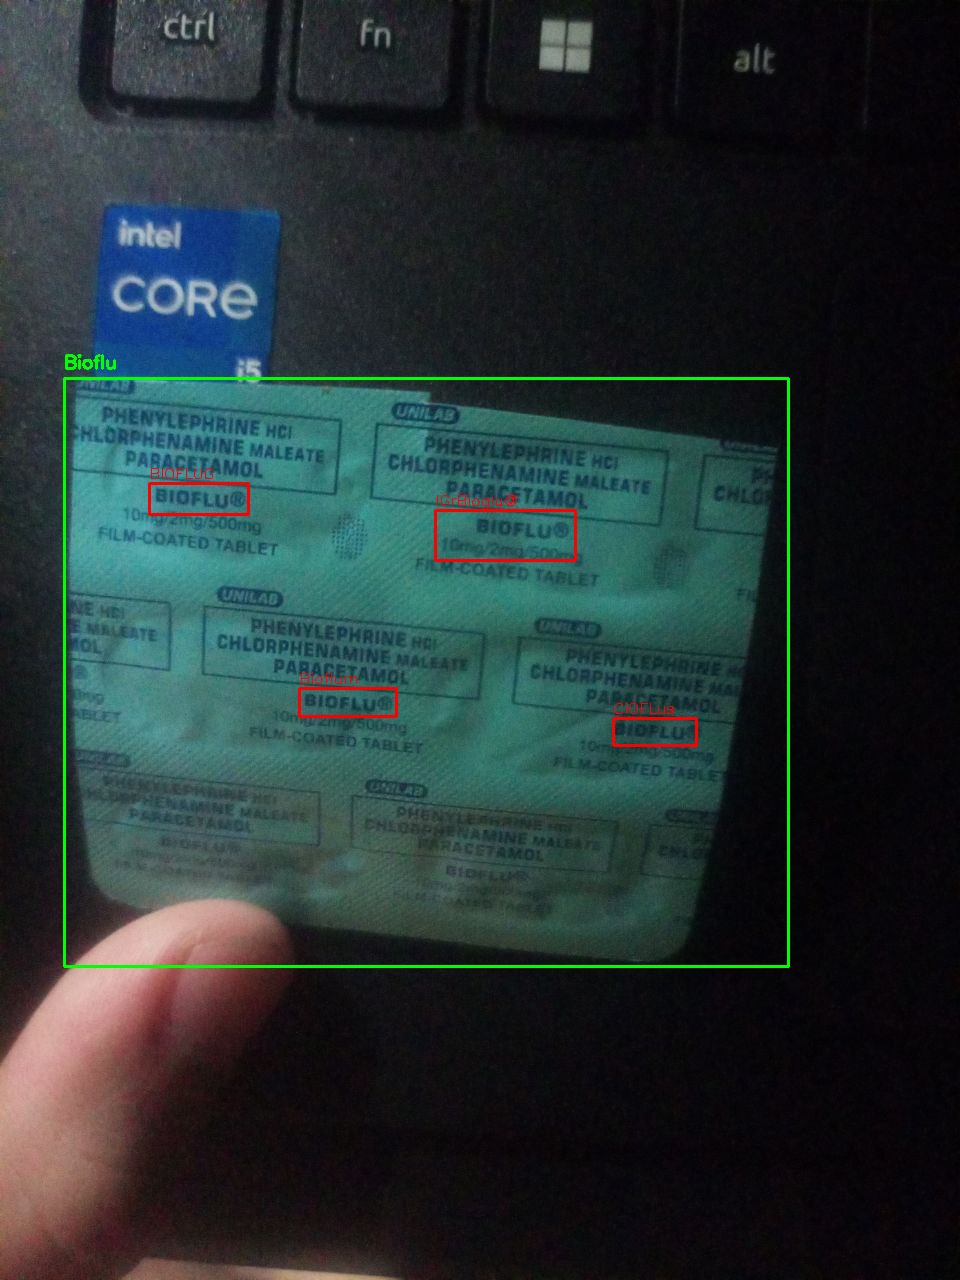

In [ ]:
import cv2
import numpy as np
import requests
from IPython.display import Image, display
import easyocr
import re
from difflib import SequenceMatcher
from dotenv import load_dotenv
import os

# Initialize EasyOCR (English only)
reader = easyocr.Reader(['en'], gpu=False)

# Load Roboflow config
load_dotenv()
API_KEY = os.getenv("ROBOFLOW_API_KEY")
MODEL_ID = ""  # Replace with your model ID
MODEL_VERSION = "1"

def text_similarity(a, b):
    """Calculate similarity ratio between two strings (0 to 1)."""
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

def detect_pills_and_highlight_text(image_path, similarity_threshold=0.7):
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Image not found!")
        return

    # --- Step 1: Detect Pills with Roboflow/YOLOv8 ---
    url = f"https://detect.roboflow.com/{MODEL_ID}/{MODEL_VERSION}"
    params = {"api_key": API_KEY, "confidence": 50, "overlap": 30}
    _, encoded_image = cv2.imencode(".jpg", image)
    response = requests.post(url, files={"file": encoded_image.tobytes()}, params=params)
    
    if response.status_code != 200:
        print(f"API Error: {response.text}")
        return

    predictions = response.json().get("predictions", [])
    print(f"Detected {len(predictions)} pills.")

    # --- Step 2: For each pill, search for text matching its class ---
    for pred in predictions:
        x, y, w, h = int(pred["x"]), int(pred["y"]), int(pred["width"]), int(pred["height"])
        x1, y1 = x - w//2, y - h//2
        x2, y2 = x + w//2, y + h//2
        pill_class = pred["class"]  # e.g., "bioflu"

        # Crop the pill region
        pill_region = image[y1:y2, x1:x2]

        # Use EasyOCR to find text in the pill region
        ocr_results = reader.readtext(pill_region)
        
        # Filter OCR results to only include text similar to the pill class
        matched_texts = []
        for (bbox, text, confidence) in ocr_results:
            similarity = text_similarity(text, pill_class)
            if similarity >= similarity_threshold:
                matched_texts.append((bbox, text, confidence))

        # Draw bounding box for the pill (YOLO detection)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green box for pill
        cv2.putText(image, pill_class, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Draw boxes around matched text (EasyOCR results)
        for (bbox, text, _) in matched_texts:
            # Convert EasyOCR bbox coordinates to image coordinates
            bbox = np.array(bbox) + np.array([x1, y1])  # Offset by pill region
            bbox = bbox.astype(int)
            cv2.polylines(image, [bbox], isClosed=True, color=(0, 0, 255), thickness=2)  # Red box for text
            cv2.putText(image, text, (bbox[0][0], bbox[0][1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Save and display
    output_path = "output_targeted_ocr.jpg"
    cv2.imwrite(output_path, image)
    display(Image(filename=output_path, width=600))

# Example usage
detect_pills_and_highlight_text("test/photo_2_2025-04-01_00-17-27.jpg", similarity_threshold=0.6)  # Adjust threshold as needed